In [1]:
import pandas as pd 
from prophet import Prophet 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

C:\Users\AWIT\Desktop\Hackithon2025CreaThon\repa\HackathonHuita\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def load_data():
    # Load datasets (example placeholders)
    df_train = pd.read_csv('./data/sell_data_cleaned.csv', sep=';', parse_dates=['Date'])
    df_campaign = pd.read_csv('./data/marketing_campaign.csv', sep=';', parse_dates=['ValidFrom', 'ValidTo'])
    df_stock = pd.read_csv('./data/stock.csv', sep=';', parse_dates=['Datum'])
    df_stock.rename(columns={'Datum': 'Date', 'AnonymniProdukt': 'Product', 'Mnozstvi': 'Stock'}, inplace=True)
    return df_train, df_campaign, df_stock

def preprocess_data(df_train, df_stock):
    # Merge stock data
    df_train = pd.merge(df_train, df_stock, on=['Product', 'Date'], how='left')
    df_train['Quantity'] = df_train.apply(lambda x: 0 if x['Stock'] == 0 else x['Quantity'], axis=1)
    
    # Create StatusCombo (critical for method3)
    required_status_cols = ['CountryStatus', 'ProductStatus']
    missing = [col for col in required_status_cols if col not in df_train.columns]
    
    if missing:
        raise KeyError(f"Missing status columns: {missing}. Required for StatusCombo.")
    
    df_train['StatusCombo'] = df_train['CountryStatus'] + df_train['ProductStatus']
    return df_train

In [3]:
def create_aggregated_data(df, group_cols, df_campaign):
        # Aggregate Quantity
    agg_df = df.groupby(group_cols + ['Date'])['Quantity'].sum().reset_index()
    
    # Process campaign data (filtered to relevant products/countries)
    products_in_data = df['Product'].unique()
    countries_in_data = df['Country'].unique() if 'Country' in df.columns else []
    
    relevant_campaigns = df_campaign[
        (df_campaign['Product'].isin(products_in_data)) &
        (df_campaign['Country'].isin(countries_in_data))
    ]
    
    # Generate campaign date ranges with explicit columns
    campaign_columns = ['Date', 'Product', 'Country', 'CampaignActive']
    campaign_dates = []
    for _, row in relevant_campaigns.iterrows():
        dates = pd.date_range(row['ValidFrom'], row['ValidTo'], freq='D')
        for date in dates:
            campaign_dates.append({
                'Date': date,
                'Product': row['Product'],
                'Country': row['Country'],
                'CampaignActive': 1
            })
    
    # Create campaign DF with guaranteed columns
    campaign_df = pd.DataFrame(campaign_dates, columns=campaign_columns)
    
    # Merge campaign activity
    if not group_cols:  # Global aggregation
        campaign_agg = campaign_df.groupby('Date')['CampaignActive'].max().reset_index()
        agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
    else:
        if 'Country' in group_cols and 'Country' in campaign_df.columns:
            # Country-level campaigns
            campaign_agg = campaign_df.groupby(['Country', 'Date'])['CampaignActive'].max().reset_index()
            merge_cols = ['Country', 'Date']
        else:
            # Product-only campaigns
            campaign_agg = campaign_df.groupby('Date')['CampaignActive'].max().reset_index()
            merge_cols = ['Date']
        agg_df = pd.merge(agg_df, campaign_agg, on=merge_cols, how='left').fillna(0)
    
    # Ensure CampaignActive exists
    agg_df['CampaignActive'] = agg_df.get('CampaignActive', 0)
    
    # Aggregate Stock features
    df['InStock'] = df['Stock'] > 0
    stock_agg = df.groupby(group_cols + ['Date'])[['Stock', 'InStock']].agg({
        'Stock': ['sum', 'mean'],
        'InStock': 'sum'
    }).reset_index()
    
    # Flatten multi-index columns
    stock_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in stock_agg.columns]
    
    # Merge stock features
    agg_df = pd.merge(agg_df, stock_agg, on=group_cols + ['Date'], how='left')
    
    # Create lag features and moving averages
    agg_df.sort_values(group_cols + ['Date'], inplace=True)
    
    for col in ['Stock_sum', 'Stock_mean', 'InStock_sum']:
        if not group_cols:  # Global scenario
            agg_df[f'{col}_lag1'] = agg_df[col].shift(1)
            agg_df[f'{col}_7d_avg'] = agg_df[col].rolling(7, min_periods=1).mean()
        else:  # Grouped scenarios
            agg_df[f'{col}_lag1'] = agg_df.groupby(group_cols)[col].shift(1)
            agg_df[f'{col}_7d_avg'] = agg_df.groupby(group_cols)[col].transform(
                lambda x: x.rolling(7, min_periods=1).mean()
            )
        
        # Fill initial NaN values
        agg_df[f'{col}_lag1'] = agg_df[f'{col}_lag1'].fillna(0)
    
    return agg_df

In [4]:
def train_test_split_chronological(df, group_cols, test_size=0.2):
    # Handle empty group_cols by adding a dummy group
    dummy_added = False
    if not group_cols:
        df = df.assign(_dummy_group=0)
        group_cols = ['_dummy_group']
        dummy_added = True

    missing = [col for col in group_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing group columns: {missing}")

    # Check for empty groups
    if df[group_cols].nunique().prod() == 0:
        raise ValueError("No valid groups for splitting")

    train_dfs, test_dfs = [], []
    for name, group in df.groupby(group_cols):
        group = group.sort_values('Date')
        split_idx = int(len(group) * (1 - test_size))
        
        # Ensure at least one test sample
        split_idx = max(1, min(split_idx, len(group)-2))
        
        train_part = group.iloc[:split_idx].copy()
        test_part = group.iloc[split_idx:].copy()
        
        # Verify temporal sequence
        assert test_part['Date'].min() > train_part['Date'].max(), \
            "Test data must start after training data"
        
        train_dfs.append(train_part)
        test_dfs.append(test_part)
    
    # Concatenate results and remove dummy if added
    train = pd.concat(train_dfs)
    test = pd.concat(test_dfs)
    
    if dummy_added:
        train = train.drop(columns=['_dummy_group'])
        test = test.drop(columns=['_dummy_group'])
        group_cols = []
    
    return train, test

In [5]:
def train_prophet(train_data, group_cols, regressors):
    models = {}
    
    # Handle empty group_cols by adding a dummy group
    dummy_added = False
    if not group_cols:
        train_data = train_data.assign(_dummy_group=0)
        group_cols = ['_dummy_group']
        dummy_added = True

    for name, group in train_data.groupby(group_cols):
        df = group.rename(columns={'Date': 'ds', 'Quantity': 'y'})
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        
        # Add regressors
        for reg in regressors:
            model.add_regressor(reg)
            
        # Fit with regressor data
        model.fit(df[['ds', 'y'] + regressors])
        
        # Use "Global" as the key if dummy was added
        if dummy_added:
            models['Global'] = model
        else:
            models[name] = model
    return models

In [6]:
def predict_and_plot(models, test_data, group_cols, regressors, segment_name=None):
    all_y_true = []
    all_y_pred = []
    
    # Handle empty group_cols by adding a dummy group
    dummy_added = False
    if not group_cols:
        test_data = test_data.assign(_dummy_group=0)
        group_cols = ['_dummy_group']
        dummy_added = True

    for name, group in test_data.groupby(group_cols):
        # Determine model key
        model_key = 'Global' if dummy_added else name
        
        # Override model key with segment_name if provided (for method4)
        title = segment_name if segment_name else model_key
        
        model = models.get(model_key)
        if not model:
            continue

        # Get training history
        train_history = model.history[['ds', 'y']].rename(
            columns={'ds': 'Date', 'y': 'Quantity'}
        )

        # Create future dataframe with test dates
        future = pd.DataFrame({'ds': pd.to_datetime(group['Date'].unique())})
        future = future.sort_values('ds').reset_index(drop=True)

        # Merge regressors from test data
        regressor_df = group.drop_duplicates('Date')[['Date'] + regressors]
        future = future.merge(regressor_df, left_on='ds', right_on='Date', how='left')
        future[regressors] = future[regressors].fillna(0)

        # Generate forecast
        forecast = model.predict(future)

        # Merge forecast with test actuals for metrics
        forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date'})
        actuals = group[['Date', 'Quantity']]
        merged = pd.merge(actuals, forecast_df, on='Date', how='inner')

        # Calculate metrics
        if not merged.empty:
            mse = mean_squared_error(merged['Quantity'], merged['yhat'])
            mae = mean_absolute_error(merged['Quantity'], merged['yhat'])
            mean_sales = merged['Quantity'].mean()
        else:
            print(f"No overlapping data for {title} - skipping metrics.")
            continue

        # Plotting logic with dynamic title
        plt.figure(figsize=(15, 6), facecolor='#242424')
        plt.plot(train_history['Date'], train_history['Quantity'], 
                 label='Train Actual', color='#fefefe')
        plt.plot(merged['Date'], merged['Quantity'], 
                 label='Test Actual', color='yellow', alpha=0.5)
        plt.plot(merged['Date'], merged['yhat'], 
                 label='Forecast', color='red', linestyle='-')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                         alpha=0.2, color='red')
        plt.axvline(train_history['Date'].max(), color='white', linestyle='--',
                     label='Train/Test Split')
        
        # Styling
        ax = plt.gca()
        ax.set_facecolor('#242424')
        ax.tick_params(axis='x', colors='#fefefe')
        ax.tick_params(axis='y', colors='#fefefe')
        ax.spines['bottom'].set_color('#fefefe')
        ax.spines['top'].set_color('#fefefe') 
        ax.spines['right'].set_color('#fefefe')
        ax.spines['left'].set_color('#fefefe')
        plt.title(f'{title} - Forecast vs Actual', color='#fefefe')  # Dynamic title
        plt.xlabel('Date', color='#fefefe') 
        plt.ylabel('Quantity', color='#fefefe')
        plt.legend(labelcolor='#fefefe', facecolor='#242424')
        plt.grid(False)
        plt.show()

        # Print metrics for this segment
        print(f"\nMetrics for {title}:")
        print(f"  MSE: {mse:.2f}")
        print(f"  MAE: {mae:.2f}")
        if mean_sales > 0:
            print(f"  MAE/Mean Sales Ratio: {(mae / mean_sales) * 100:.2f}%")
        print("─" * 50)

    # Cleanup dummy column if added
    if dummy_added:
        test_data.drop(columns=['_dummy_group'], inplace=True)

In [7]:
def method1(df_train, df_campaign):
    print("Method 1 proccessing: ")
    
    # Country-level aggregation
    agg_df = create_aggregated_data(df_train, ['Country'], df_campaign)
    train, test = train_test_split_chronological(agg_df, ['Country'])
    regressors = ['CampaignActive', 'Stock_sum_lag1', 'InStock_sum_7d_avg']
    models = train_prophet(train, ['Country'], regressors)
    predict_and_plot(models, test, ['Country'], regressors)

def method2(df_train, df_campaign):
    print("Method 2 proccessing")
    # Global aggregation
    agg_df = create_aggregated_data(df_train, [], df_campaign)
    train, test = train_test_split_chronological(agg_df, [])
    regressors = ['CampaignActive', 'Stock_sum_lag1', 'InStock_sum_7d_avg']
    models = train_prophet(train, [], regressors)  # Returns {'Global': model}
    predict_and_plot(models, test, [], regressors)
    
def method3(df_train, df_campaign):
    print("Method 3 proccessing: StatusCombo Aggregation")
    
    # Validate required columns
    if 'StatusCombo' not in df_train.columns:
        raise KeyError("'StatusCombo' column missing. Verify preprocessing steps.")
    
    # Status combination aggregation
    agg_df = create_aggregated_data(
        df_train, 
        group_cols=['StatusCombo'], 
        df_campaign=df_campaign
    )
    
    # Split data
    train, test = train_test_split_chronological(agg_df, ['StatusCombo'])
    
    # Train and predict
    regressors = ['CampaignActive', 'Stock_sum_lag1', 'InStock_sum_7d_avg']
    models = train_prophet(train, ['StatusCombo'], regressors)
    predict_and_plot(models, test, ['StatusCombo'], regressors)
    
def method4(df_train, df_campaign, product_country_list):
    print("Method 4: Product-Country-Level Training & Prediction")
    
    # Verify Country column exists
    if 'Country' not in df_train.columns:
        raise KeyError("'Country' column missing - check preprocessing")
    
    for product, country in product_country_list:
        print(f"\nProcessing {product} in {country}")
        
        # Validate product/country existence first
        valid_products = df_train['Product'].unique()
        valid_countries = df_train['Country'].unique()
        
        if product not in valid_products:
            print(f"Product {product} not found in data. Valid options: {valid_products}")
            continue
        if country not in valid_countries:
            print(f"Country {country} not found. Valid options: {valid_countries}")
            continue
            
        # Filter data
        mask = (df_train['Product'] == product) & (df_train['Country'] == country)
        subset = df_train[mask].copy()
        
        if subset.empty:
            print(f"No data for {product} in {country} - check input")
            continue
            
        # Rest of processing
        agg_df = create_aggregated_data(subset, [], df_campaign)
        
        if len(agg_df) < 14:
            print(f"Only {len(agg_df)} days of data for {product}-{country}")
            continue
            
        try:
            train, test = train_test_split_chronological(agg_df, [], test_size=0.2)
        except Exception as e:
            print(f"Split failed: {str(e)}")
            continue
            
        regressors = ['CampaignActive', 'Stock_sum_lag1', 'InStock_sum_7d_avg']
        models = train_prophet(train, [], regressors)
        predict_and_plot(models, test, [], regressors, segment_name=f"{product}-{country}")

In [8]:
df_train, df_campaign, df_stock = load_data()
df_train = preprocess_data(df_train, df_stock)

Method 1 proccessing: 


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on=merge_cols, how='left').fillna(0)
13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing


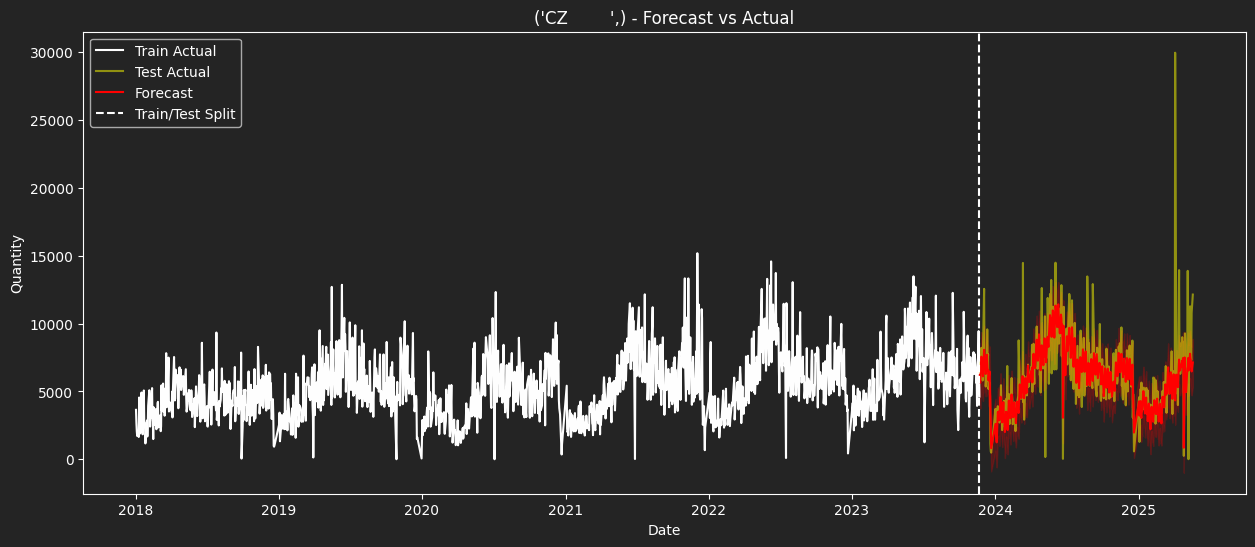


Metrics for ('CZ        ',):
  MSE: 4803912.97
  MAE: 1256.58
  MAE/Mean Sales Ratio: 20.06%
──────────────────────────────────────────────────


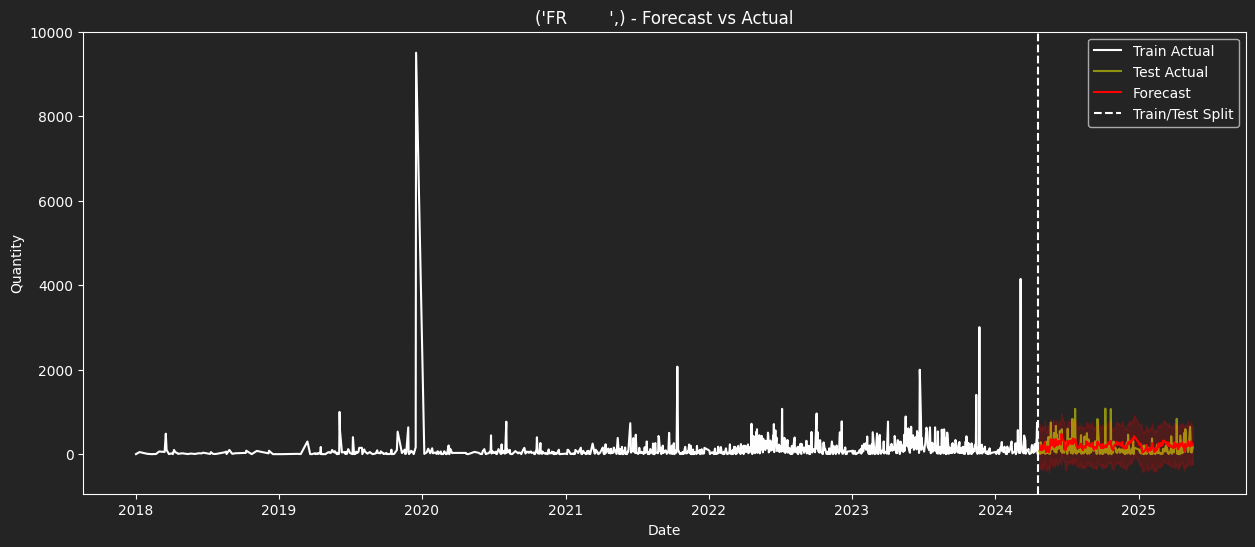


Metrics for ('FR        ',):
  MSE: 38561.97
  MAE: 156.97
  MAE/Mean Sales Ratio: 102.37%
──────────────────────────────────────────────────


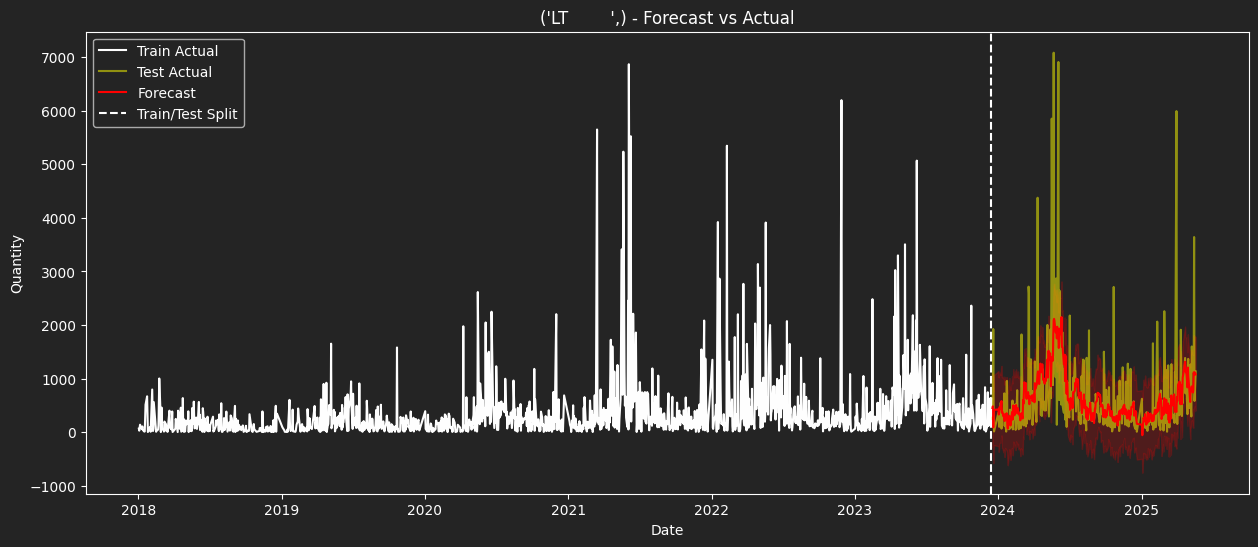


Metrics for ('LT        ',):
  MSE: 601450.30
  MAE: 418.60
  MAE/Mean Sales Ratio: 62.48%
──────────────────────────────────────────────────


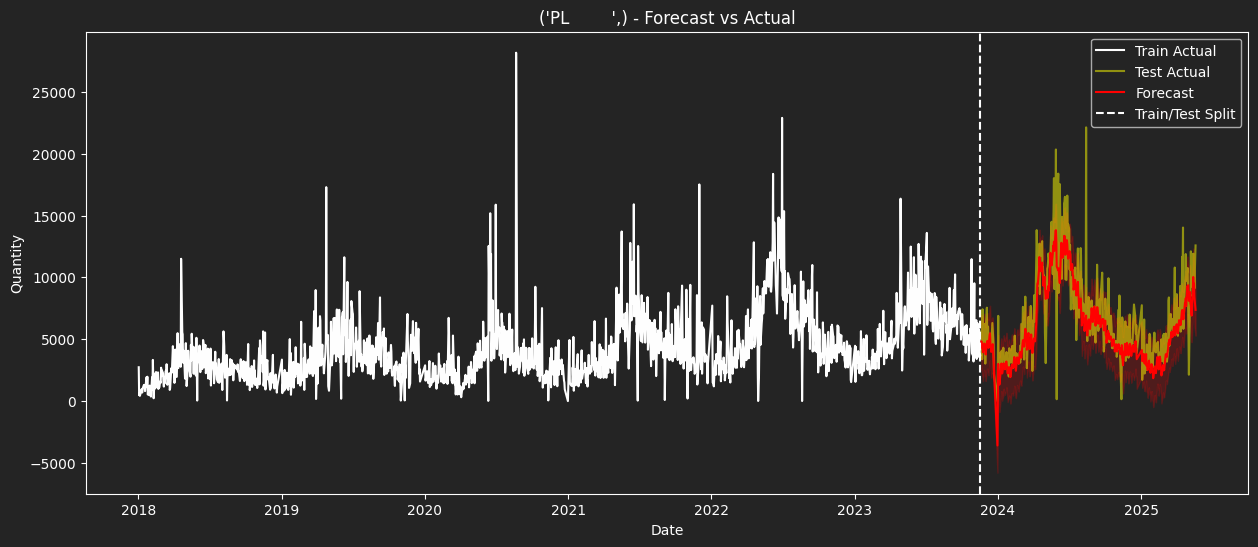


Metrics for ('PL        ',):
  MSE: 5103758.05
  MAE: 1588.09
  MAE/Mean Sales Ratio: 22.84%
──────────────────────────────────────────────────


In [9]:
method1(df_train, df_campaign)

Method 2 proccessing


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing


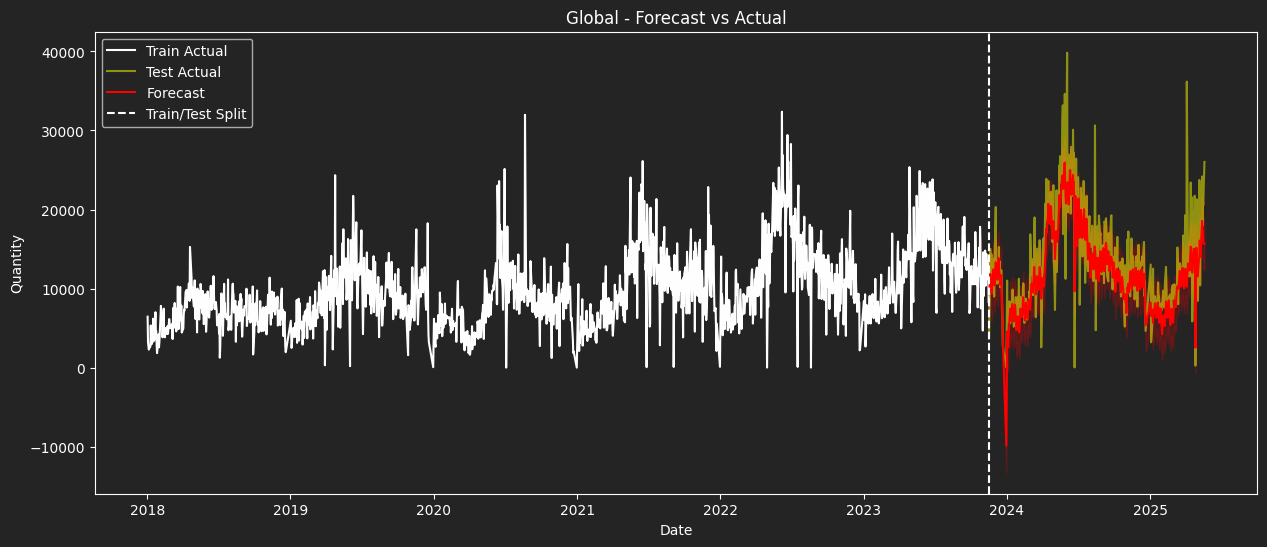


Metrics for Global:
  MSE: 14509763.63
  MAE: 2714.45
  MAE/Mean Sales Ratio: 19.69%
──────────────────────────────────────────────────


In [10]:
method2(df_train, df_campaign)

Method 3 proccessing: StatusCombo Aggregation


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on=merge_cols, how='left').fillna(0)
13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:45 - cmdstanpy - INFO - Chain [1] done processing


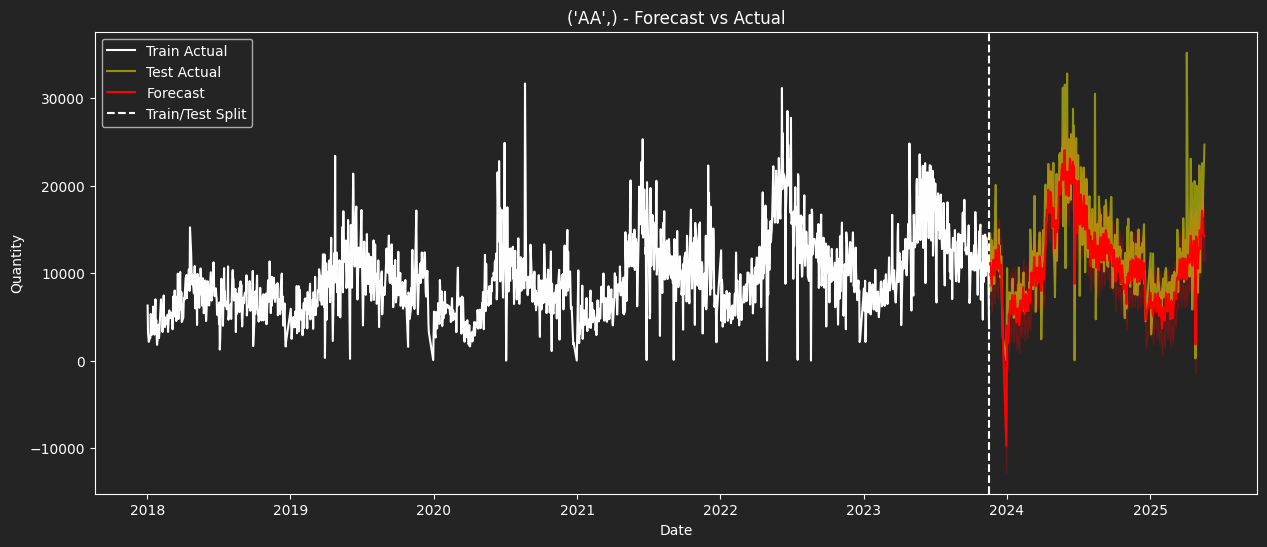


Metrics for ('AA',):
  MSE: 13344261.19
  MAE: 2627.48
  MAE/Mean Sales Ratio: 20.20%
──────────────────────────────────────────────────


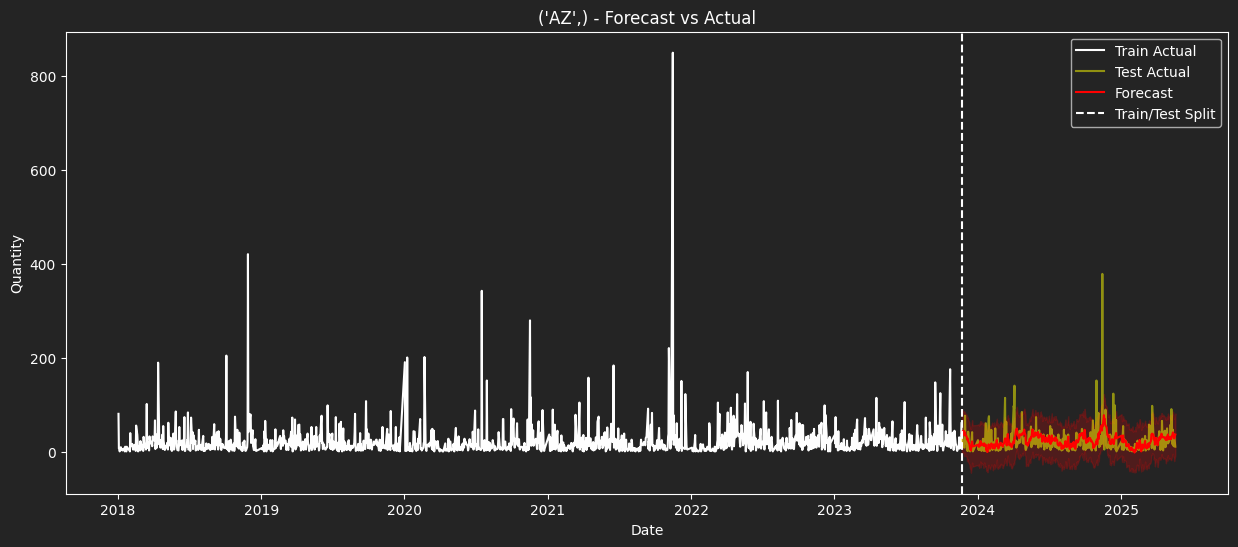


Metrics for ('AZ',):
  MSE: 750.64
  MAE: 15.47
  MAE/Mean Sales Ratio: 67.09%
──────────────────────────────────────────────────


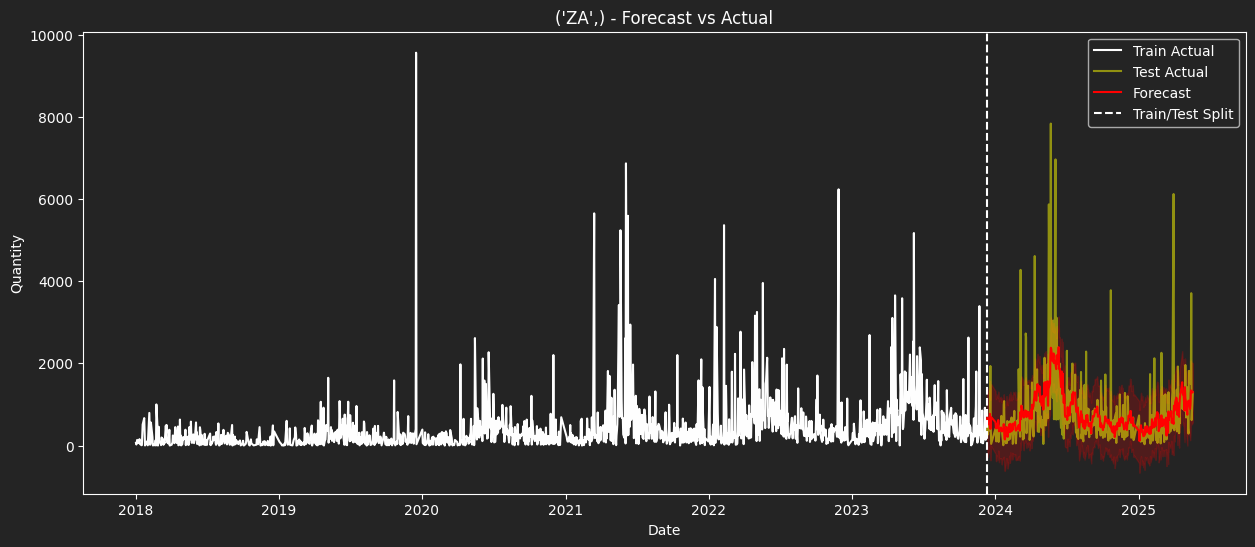


Metrics for ('ZA',):
  MSE: 662858.57
  MAE: 463.32
  MAE/Mean Sales Ratio: 57.59%
──────────────────────────────────────────────────


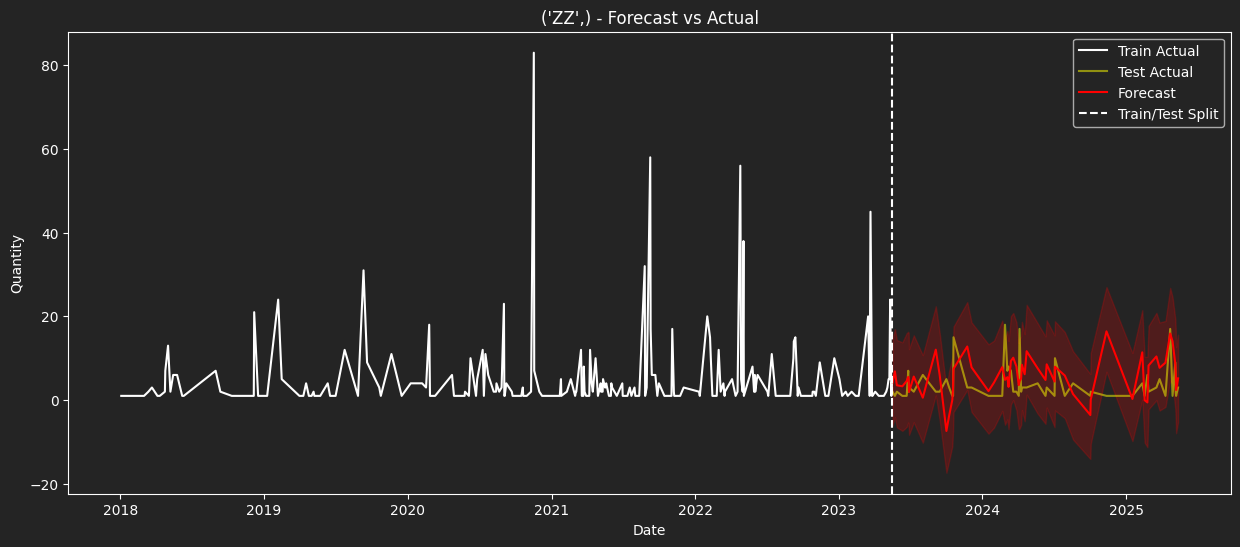


Metrics for ('ZZ',):
  MSE: 36.05
  MAE: 4.85
  MAE/Mean Sales Ratio: 126.64%
──────────────────────────────────────────────────


In [11]:
method3(df_train, df_campaign)

Method 4: Product-Country-Level Training & Prediction

Processing ProduktX2485 in CZ        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing


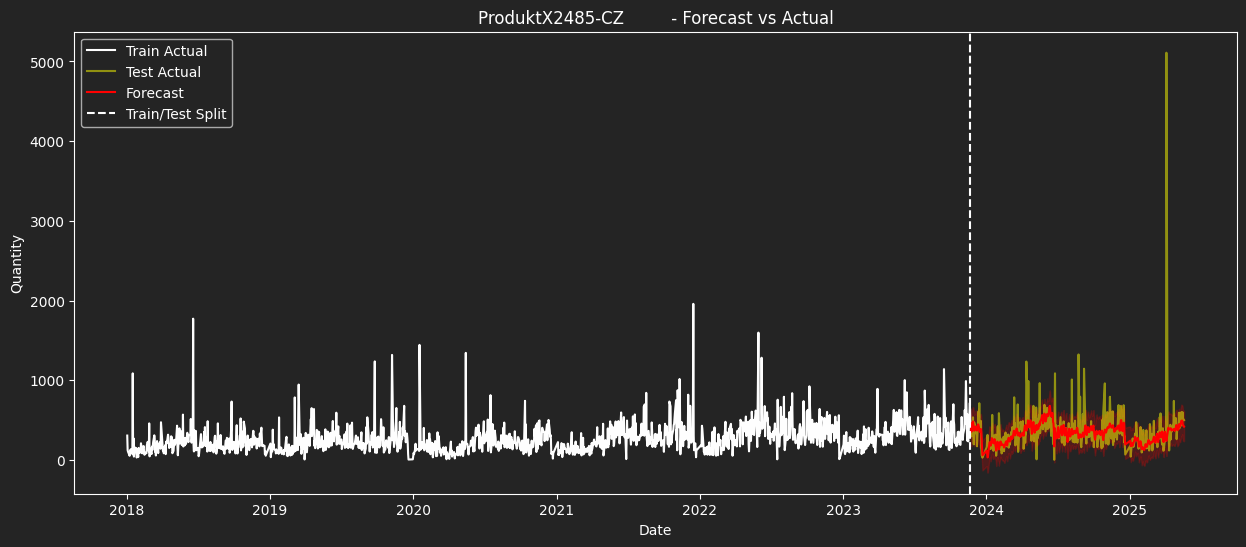


Metrics for ProduktX2485-CZ        :
  MSE: 92290.46
  MAE: 123.13
  MAE/Mean Sales Ratio: 34.20%
──────────────────────────────────────────────────

Processing ProduktX2486 in CZ        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing


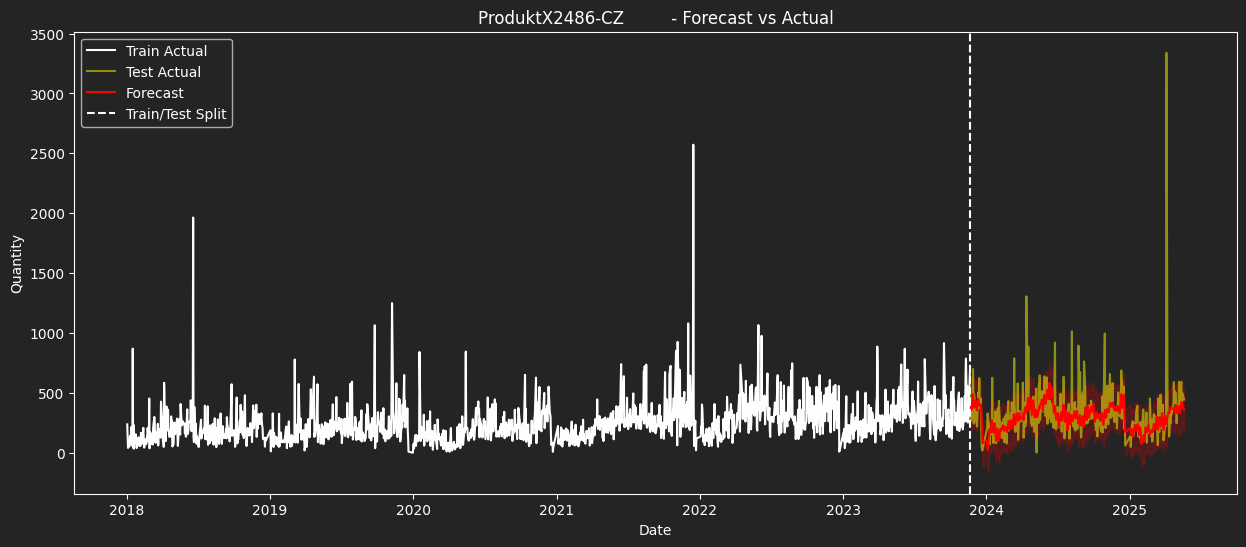


Metrics for ProduktX2486-CZ        :
  MSE: 48100.13
  MAE: 108.86
  MAE/Mean Sales Ratio: 33.30%
──────────────────────────────────────────────────
Method 4: Product-Country-Level Training & Prediction

Processing ProduktX2485 in FR        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:06 - cmdstanpy - INFO - Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing


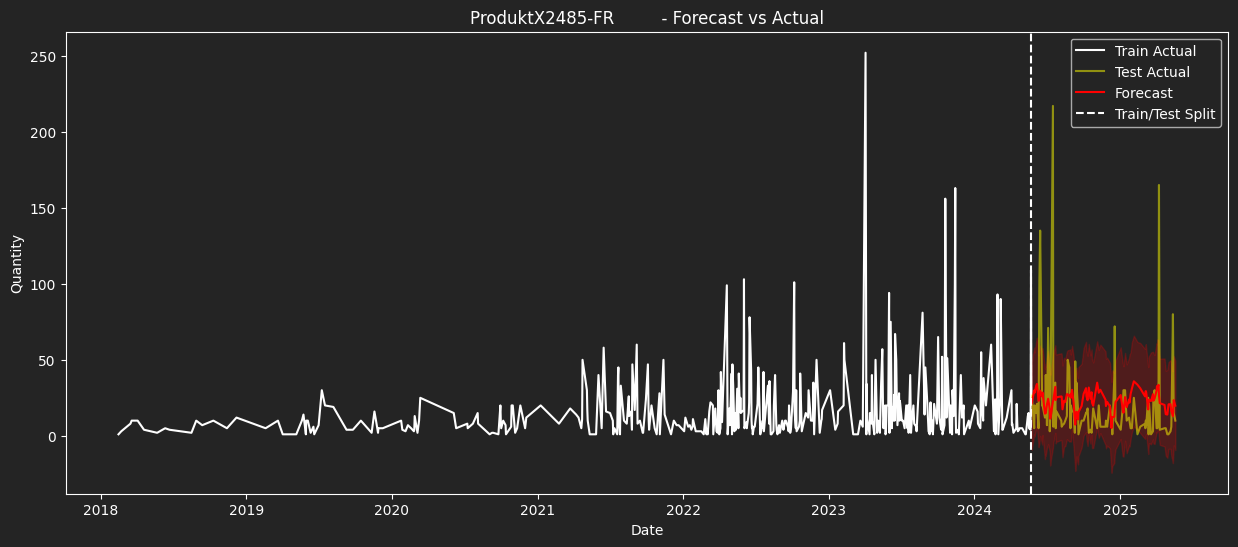


Metrics for ProduktX2485-FR        :
  MSE: 1095.87
  MAE: 20.41
  MAE/Mean Sales Ratio: 94.79%
──────────────────────────────────────────────────

Processing ProduktX2486 in FR        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


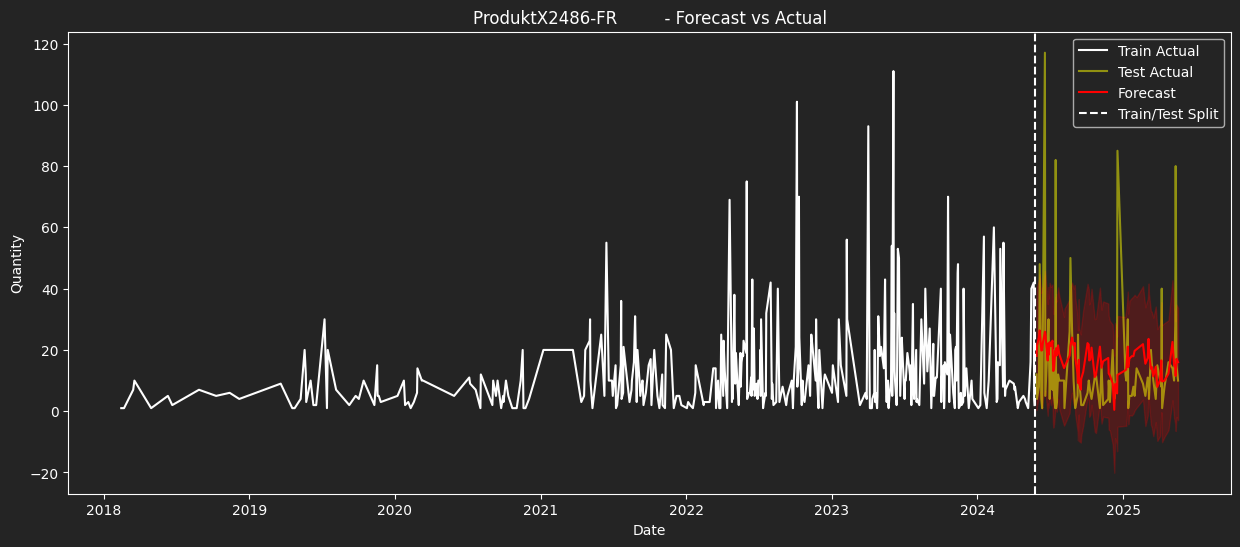


Metrics for ProduktX2486-FR        :
  MSE: 388.55
  MAE: 12.82
  MAE/Mean Sales Ratio: 84.33%
──────────────────────────────────────────────────
Method 4: Product-Country-Level Training & Prediction

Processing ProduktX2485 in LT        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


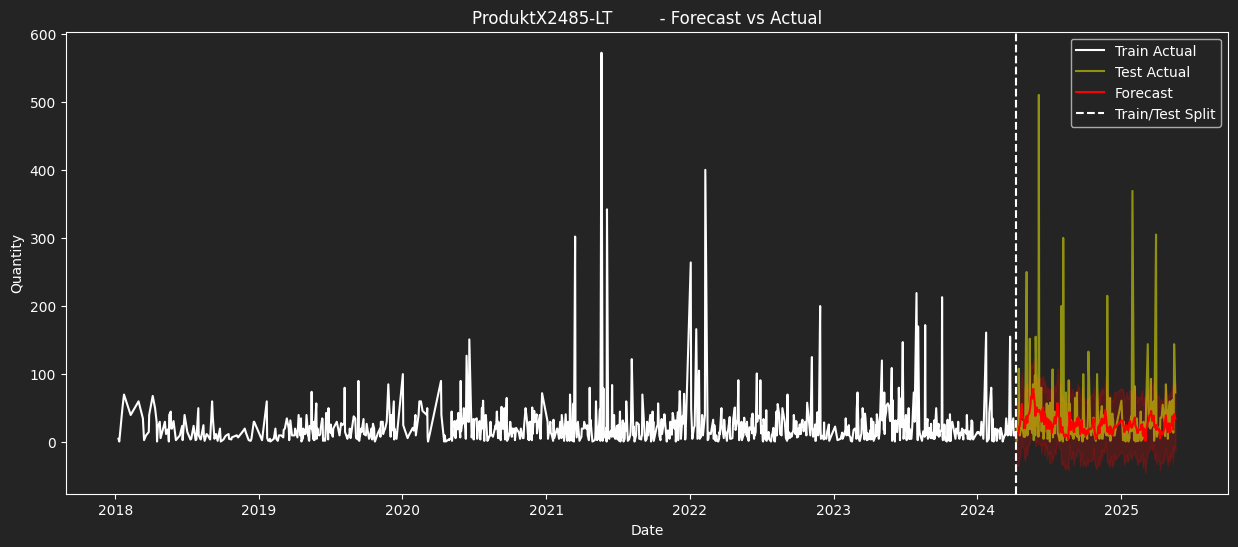


Metrics for ProduktX2485-LT        :
  MSE: 3571.77
  MAE: 28.81
  MAE/Mean Sales Ratio: 73.35%
──────────────────────────────────────────────────

Processing ProduktX2486 in LT        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing


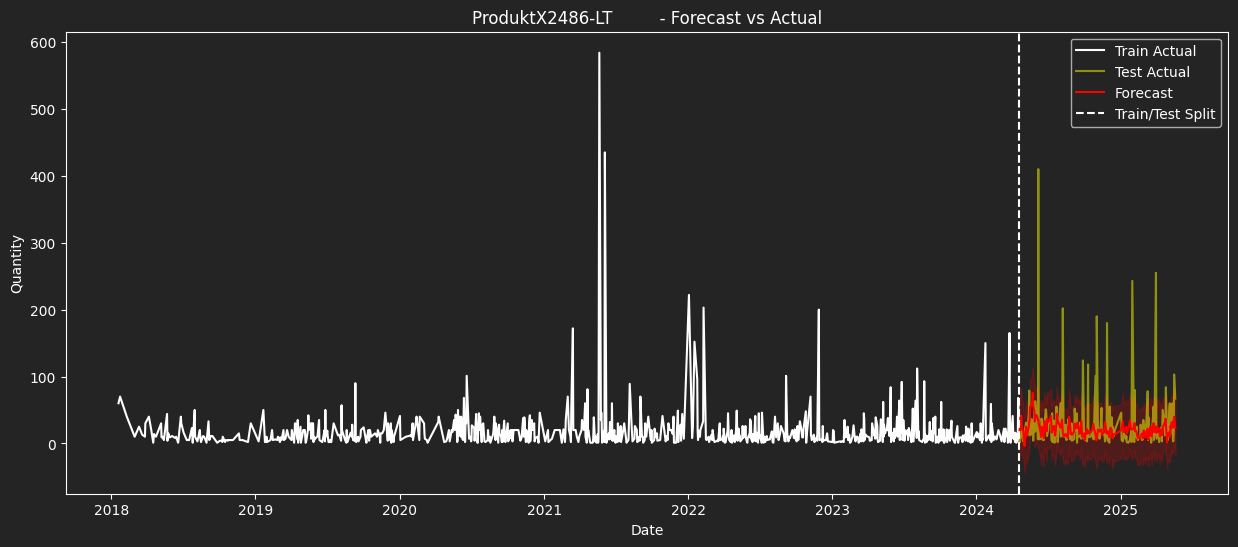


Metrics for ProduktX2486-LT        :
  MSE: 2144.47
  MAE: 21.50
  MAE/Mean Sales Ratio: 74.01%
──────────────────────────────────────────────────
Method 4: Product-Country-Level Training & Prediction

Processing ProduktX2485 in PL        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing


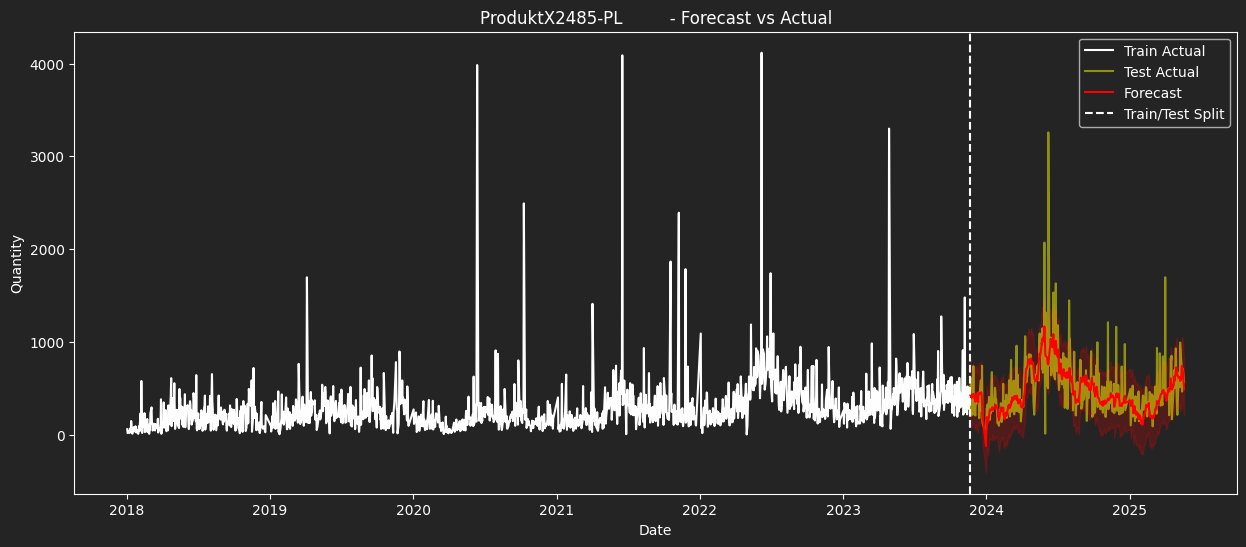


Metrics for ProduktX2485-PL        :
  MSE: 63048.44
  MAE: 155.21
  MAE/Mean Sales Ratio: 30.59%
──────────────────────────────────────────────────

Processing ProduktX2486 in PL        


C:\Users\AWIT\AppData\Local\Temp\ipykernel_28372\1202524015.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_df = pd.merge(agg_df, campaign_agg, on='Date', how='left').fillna(0)
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing


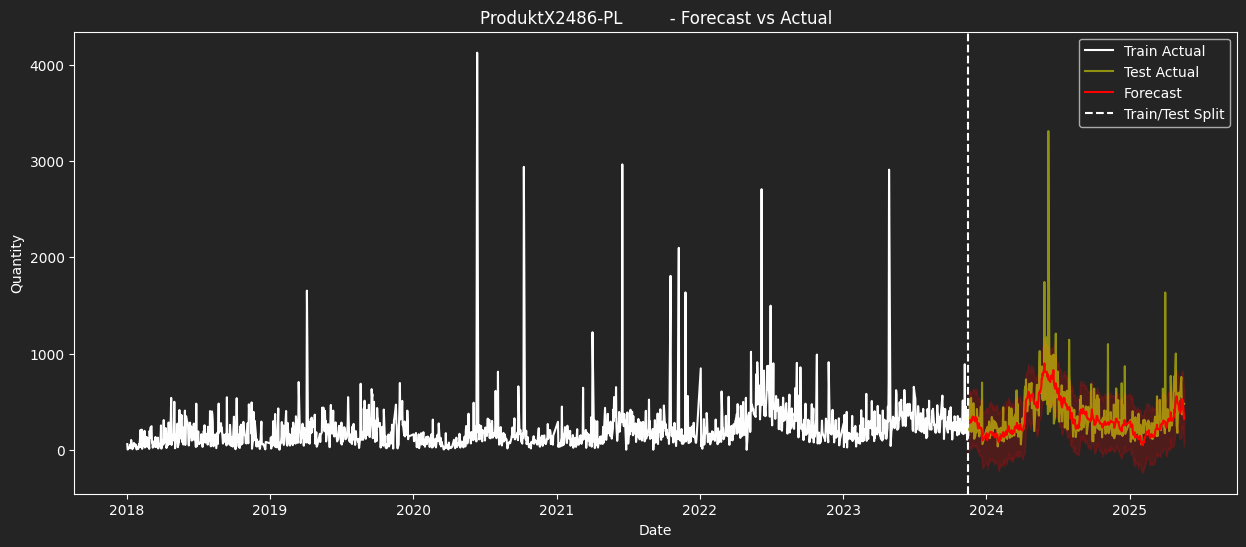


Metrics for ProduktX2486-PL        :
  MSE: 52765.98
  MAE: 134.66
  MAE/Mean Sales Ratio: 35.68%
──────────────────────────────────────────────────


In [17]:
all_countries = df_train['Country'].unique()
for country in all_countries:
    method4(df_train, df_campaign, [('ProduktX2485', country), ('ProduktX2486', country)])
